### Installs

In [ ]:
# Install necessary packages
!pip install --upgrade ultralytics

### Imports

In [11]:
# Import required modules
import os
import re
import glob
import random
import uuid
import pandas as pd
import torch
from ultralytics import YOLO
from IPython.display import Image, display

# import locale
# locale.getpreferredencoding = lambda: 'UTF-8'

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")

Using cuda device


### Define Paths

In [12]:
# ============================================
# Step 1: Define Dataset Paths and Class Names
# ============================================

# Define the directory where your dataset is stored (modify this path if necessary)
DATASET_PATH = '/content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset'

# Define paths to the images and labels directories
train_images_dir = os.path.join(DATASET_PATH, 'train', 'images')
train_labels_dir = os.path.join(DATASET_PATH, 'train', 'labels')

val_images_dir = os.path.join(DATASET_PATH, 'val', 'images')
val_labels_dir = os.path.join(DATASET_PATH, 'val', 'labels')

test_images_dir = os.path.join(DATASET_PATH, 'test', 'images')
test_labels_dir = os.path.join(DATASET_PATH, 'test', 'labels')

### Data Preparation and Cleaning for Pallet and Ground Segmentation

This code defines classes, cleans duplicate annotations, and checks class distribution across training, validation, and testing datasets to ensure balanced segmentation data.


In [13]:
# Define class names
class_names = ['ground', 'pallet']

# ============================================
# Step 2: Data Cleaning - Remove Duplicate Labels
# ============================================

def remove_duplicate_labels(labels_dir):
    """
    Removes duplicate label entries from annotation files.
    """
    for label_file in os.listdir(labels_dir):
        label_path = os.path.join(labels_dir, label_file)
        with open(label_path, 'r') as f:
            lines = f.readlines()
        unique_lines = list(set(lines))
        if len(lines) != len(unique_lines):
            with open(label_path, 'w') as f:
                f.writelines(unique_lines)
            print(f"Removed duplicates in {label_file}")

print("Cleaning training labels...")
remove_duplicate_labels(train_labels_dir)

print("Cleaning validation labels...")
remove_duplicate_labels(val_labels_dir)

print("Cleaning test labels...")
remove_duplicate_labels(test_labels_dir)

# ============================================
# Step 3: Verify and Balance Dataset
# ============================================

def get_class_distribution(labels_dir):
    """
    Returns the distribution of classes in the dataset.
    """
    class_counts = {}
    for label_file in os.listdir(labels_dir):
        label_path = os.path.join(labels_dir, label_file)
        with open(label_path, 'r') as f:
            for line in f:
                class_id = int(line.strip().split()[0])
                class_counts[class_id] = class_counts.get(class_id, 0) + 1
    return class_counts

train_class_counts = get_class_distribution(train_labels_dir)
val_class_counts = get_class_distribution(val_labels_dir)
test_class_counts = get_class_distribution(test_labels_dir)

print("Train Class Distribution:", train_class_counts)
print("Validation Class Distribution:", val_class_counts)
print("Test Class Distribution:", test_class_counts)

Cleaning training labels...
Cleaning validation labels...
Cleaning test labels...
Train Class Distribution: {0: 1472, 1: 3730}
Validation Class Distribution: {0: 170, 1: 339}
Test Class Distribution: {0: 172, 1: 368}


### Dataset Configuration and Model Initialization

Creates a `data.yaml` file if it doesn't exist to define dataset paths, class names, and count, followed by initializing the YOLOv11x model with a pre-trained checkpoint.


In [14]:
# ============================================
# Step 4: Create data.yaml
# ============================================

# Define the path to the data.yaml file
data_yaml_path = os.path.join(DATASET_PATH, 'data.yaml')

# Check if data.yaml exists, and if not, create it
if not os.path.exists(data_yaml_path):
    data_yaml_content = f"""
train: {train_images_dir}
val: {val_images_dir}
test: {test_images_dir}

nc: 2
names: ['ground', 'pallet']
"""
    # Write the content to data.yaml
    with open(data_yaml_path, 'w') as f:
        f.write(data_yaml_content)
    print(f"Created data.yaml at {data_yaml_path}")
else:
    print(f"data.yaml already exists at {data_yaml_path}")

# ============================================
# Step 5: Model Initialization and Configuration
# ============================================

# Path to the pre-trained YOLO11x model
YOLOV11X_MODEL_PATH = '/content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/models/yolo11x.pt'

# Initialize the model
model = YOLO(YOLOV11X_MODEL_PATH)

data.yaml already exists at /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/data.yaml


In [15]:
# ============================================
# Step 6: Hyperparameter Configuration
# ============================================

# Early stopping parameters
PATIENCE = 5            # Reduced patience
MIN_DELTA = 0.0005      # Reduced minimum delta for improvement

# Training parameters
max_epochs = 50
save_dir = 'runs/pallet_detection'  # Directory to save training runs and best model

# Ensure the save directory exists
os.makedirs(save_dir, exist_ok=True)

# Define training configuration
training_config = {
    "data": data_yaml_path,
    "imgsz": 640,
    "batch": 8,  # Reduced batch size if using a larger model
    "workers": 4,
    "device": device,
    "name": 'pallet_detection',
    "pretrained": True,
    "amp": True,
    "save_dir": save_dir,
    "lr0": 0.01,
    "lrf": 0.1,
    "optimizer": 'SGD',
    "momentum": 0.937,
    "weight_decay": 0.0005,
    "warmup_epochs": 3.0,
    "warmup_momentum": 0.8,
    "warmup_bias_lr": 0.1,
    "box": 7.5,
    "cls": 0.5,
    "dfl": 1.5,
    "hsv_h": 0.015,
    "hsv_s": 0.7,
    "hsv_v": 0.4,
    "degrees": 0.0,
    "translate": 0.1,
    "scale": 0.5,
    "shear": 0.0,
    "perspective": 0.0,
    "flipud": 0.0,
    "fliplr": 0.5,
    "mosaic": 1.0,
    "mixup": 0.0,
    "copy_paste": 0.0,
    "freeze": 0,
}

### Training Loop with Early Stopping

Implements a training loop with early stopping based on mAP improvement. Saves the best model and visualizes training and validation results after each epoch.


In [1]:
# ============================================
# Step 7: Training Loop with Early Stopping
# ============================================

# Initialize variables for early stopping
best_map = 0.0         # Best mAP@0.50:0.95
patience_counter = 0   # Counter for patience

# Start training
for epoch in range(1, max_epochs + 1):
    print(f"\nEpoch {epoch}/{max_epochs}")

    # Train for one epoch with the specified hyperparameters
    results = model.train(
        epochs=1,  # Train one epoch at a time
        **training_config
    )

    # Validate the model
    print("Validating...")
    val_metrics = model.val(
        data=training_config["data"],
        split='val',
        imgsz=training_config["imgsz"],
        batch=8,  # Match training batch size
        device=training_config["device"],
        save_dir=save_dir
    )

    # Extract mAP@0.50:0.95 from validation metrics
    try:
        current_map = val_metrics.box.map  # mAP@0.50:0.95
    except AttributeError:
        print("Unable to extract mAP from validation metrics. Inspecting `val_metrics`...")
        print(val_metrics)
        break

    print(f"Validation mAP@0.50:0.95: {current_map:.4f}")

    # Check for improvement
    if current_map > best_map + MIN_DELTA:
        best_map = current_map
        patience_counter = 0
        print(f"Validation mAP improved to {current_map:.4f}, saving best model.")

        # Save the best model
        best_model_path = os.path.join(save_dir, 'best_model.pt')
        model.save(best_model_path)
    else:
        patience_counter += 1
        print(f"No improvement in mAP for {patience_counter} consecutive epoch(s).")

    # Check if patience has been exceeded
    if patience_counter >= PATIENCE:
        print(f"Early stopping triggered. No improvement in mAP for {PATIENCE} consecutive epochs.")
        break

    # Clear GPU memory to prevent fragmentation
    torch.cuda.empty_cache()

    # Optionally, display training and validation results after each epoch
    results_image = os.path.join(save_dir, 'results.png')
    confusion_matrix_image = os.path.join(save_dir, 'confusion_matrix.png')

    if os.path.exists(results_image):
        print("Training Results:")
        display(Image(filename=results_image, width=600))

    if os.path.exists(confusion_matrix_image):
        print("Confusion Matrix:")
        display(Image(filename=confusion_matrix_image, width=600))

print("\nTraining completed.")
print(f"Best validation mAP@0.50:0.95: {best_map:.4f}")
print(f"Best model saved at: {best_model_path}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.8/883.8 kB 53.2 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Using cuda device
Cleaning training labels...
Cleaning validation labels...
Cleaning test labels...
Train Class Distribution: {0: 1472, 1: 3730}
Validation Class Distribution: {0: 170, 1: 339}
Test Class Distribution: {0: 172, 1: 368}
data.yaml already exists at /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/data.yaml

Epoch 1/50
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/models/yolo11x.pt, data=/content/drive/MyDrive/Pallet

100%|██████████| 755k/755k [00:00<00:00, 117MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      2784  ultralytics.nn.modules.conv.Conv             [3, 96, 3, 2]                 
  1                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  2                  -1  2    389760  ultralytics.nn.modules.block.C3k2            [192, 384, 2, True, 0.25]     
  3                  -1  1   1327872  ultralytics.nn.modules.conv.Conv             [384, 384, 3, 2]              
  4                  -1  2   1553664  ultralytics.nn.modules.block.C3k2            [384, 768, 2, True, 0.25]     
  5                  -1  1   5309952  ultralytics.nn.modules.conv.Conv             [768, 768, 3, 2]              
  6                  -1  2   5022720  ultralytics.nn.modules.block.C3k2            [768, 768, 2, True]           
  7                  -1  1   5309952  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 355MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/labels.cache... 1259 images, 3 backgrounds, 0 corrupt: 100%|██████████| 1259/1259 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1000736-6303_jpg.rf.92c0d6c8403755071eac22527c9ad815_aug3.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1523528-9928_jpg.rf.72b97fae61b01490e09a48651b90339c_aug5.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1564562557492-99_jpg.rf.b550ba087e81ef90e4d318db7b52f0fa.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1564562832-8766208_jpg.rf.cee398e3c4c70e105b80a8d83bb2ab4f.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1564563664-6003265_jpg.rf.0f085ae1692f3a4bed589f00aecf5383.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pal

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/labels.cache... 157 images, 0 backgrounds, 0 corrupt: 100%|██████████| 157/157 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1574674971-1990623_jpg.rf.089a1c6aae8c5e30197a1420727b1755_aug1.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1576592474280-3_jpg.rf.adbe9cac50b24f3fc1d30e5cfb671e52.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1579165389-0477474_jpg.rf.a30f9a007f8f5b63ab44b397958d84ea_aug3.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/3195243-8649_jpg.rf.489a82ed8f86ba04d6e41b566a5bce3b_aug4.jpg: 1 duplicate labels removed


Plotting labels to runs/detect/pallet_detection/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/pallet_detection
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      9.19G      1.132      2.121      1.431        120        640: 100%|██████████| 158/158 [04:24<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


                   all        157        505      0.561       0.59      0.574      0.458

1 epochs completed in 0.079 hours.
Optimizer stripped from runs/detect/pallet_detection/weights/last.pt, 114.4MB
Optimizer stripped from runs/detect/pallet_detection/weights/best.pt, 114.4MB

Validating runs/detect/pallet_detection/weights/best.pt...
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLO11x summary (fused): 464 layers, 56,829,334 parameters, 0 gradients, 194.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


                   all        157        505      0.561      0.587      0.575      0.458
                ground        156        170      0.851      0.894      0.934      0.803
                pallet        104        335      0.272      0.279      0.216      0.114
Speed: 0.2ms preprocess, 13.1ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/pallet_detection
Validating...
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLO11x summary (fused): 464 layers, 56,829,334 parameters, 0 gradients, 194.4 GFLOPs


val: Scanning /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/labels.cache... 157 images, 0 backgrounds, 0 corrupt: 100%|██████████| 157/157 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1574674971-1990623_jpg.rf.089a1c6aae8c5e30197a1420727b1755_aug1.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1576592474280-3_jpg.rf.adbe9cac50b24f3fc1d30e5cfb671e52.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1579165389-0477474_jpg.rf.a30f9a007f8f5b63ab44b397958d84ea_aug3.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/3195243-8649_jpg.rf.489a82ed8f86ba04d6e41b566a5bce3b_aug4.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.17it/s]


                   all        157        505      0.563       0.59      0.574      0.458
                ground        156        170       0.85      0.894      0.932      0.801
                pallet        104        335      0.275      0.287      0.216      0.114
Speed: 0.2ms preprocess, 22.3ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/pallet_detection2
Validation mAP@0.50:0.95: 0.4575
Validation mAP improved to 0.4575, saving best model.

Epoch 2/50
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/models/yolo11x.pt, data=/content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/data.yaml, epochs=1, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=4, project=None, name=pallet_detection3, exist_ok=False, pretrained=True, optimizer

train: Scanning /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/labels.cache... 1259 images, 3 backgrounds, 0 corrupt: 100%|██████████| 1259/1259 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1000736-6303_jpg.rf.92c0d6c8403755071eac22527c9ad815_aug3.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1523528-9928_jpg.rf.72b97fae61b01490e09a48651b90339c_aug5.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1564562557492-99_jpg.rf.b550ba087e81ef90e4d318db7b52f0fa.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1564562832-8766208_jpg.rf.cee398e3c4c70e105b80a8d83bb2ab4f.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1564563664-6003265_jpg.rf.0f085ae1692f3a4bed589f00aecf5383.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pal


val: Scanning /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/labels.cache... 157 images, 0 backgrounds, 0 corrupt: 100%|██████████| 157/157 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1574674971-1990623_jpg.rf.089a1c6aae8c5e30197a1420727b1755_aug1.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1576592474280-3_jpg.rf.adbe9cac50b24f3fc1d30e5cfb671e52.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1579165389-0477474_jpg.rf.a30f9a007f8f5b63ab44b397958d84ea_aug3.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/3195243-8649_jpg.rf.489a82ed8f86ba04d6e41b566a5bce3b_aug4.jpg: 1 duplicate labels removed


Plotting labels to runs/detect/pallet_detection3/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/pallet_detection3
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      9.24G      1.865          2      1.993        120        640: 100%|██████████| 158/158 [00:58<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


                   all        157        505       0.68      0.573      0.584      0.419

1 epochs completed in 0.027 hours.
Optimizer stripped from runs/detect/pallet_detection3/weights/last.pt, 114.4MB
Optimizer stripped from runs/detect/pallet_detection3/weights/best.pt, 114.4MB

Validating runs/detect/pallet_detection3/weights/best.pt...
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLO11x summary (fused): 464 layers, 56,829,334 parameters, 0 gradients, 194.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


                   all        157        505      0.684      0.573      0.584      0.419
                ground        156        170      0.826      0.835      0.853      0.683
                pallet        104        335      0.543       0.31      0.315      0.154
Speed: 0.2ms preprocess, 12.8ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/pallet_detection3
Validating...
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLO11x summary (fused): 464 layers, 56,829,334 parameters, 0 gradients, 194.4 GFLOPs


val: Scanning /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/labels.cache... 157 images, 0 backgrounds, 0 corrupt: 100%|██████████| 157/157 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1574674971-1990623_jpg.rf.089a1c6aae8c5e30197a1420727b1755_aug1.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1576592474280-3_jpg.rf.adbe9cac50b24f3fc1d30e5cfb671e52.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1579165389-0477474_jpg.rf.a30f9a007f8f5b63ab44b397958d84ea_aug3.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/3195243-8649_jpg.rf.489a82ed8f86ba04d6e41b566a5bce3b_aug4.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.13it/s]


                   all        157        505      0.681      0.573      0.585      0.419
                ground        156        170      0.816      0.835      0.853      0.684
                pallet        104        335      0.546       0.31      0.317      0.155
Speed: 0.2ms preprocess, 22.0ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/pallet_detection32
Validation mAP@0.50:0.95: 0.4194
No improvement in mAP for 1 consecutive epoch(s).

Epoch 3/50
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/models/yolo11x.pt, data=/content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/data.yaml, epochs=1, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=4, project=None, name=pallet_detection4, exist_ok=False, pretrained=True, optimizer=SG

train: Scanning /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/labels.cache... 1259 images, 3 backgrounds, 0 corrupt: 100%|██████████| 1259/1259 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1000736-6303_jpg.rf.92c0d6c8403755071eac22527c9ad815_aug3.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1523528-9928_jpg.rf.72b97fae61b01490e09a48651b90339c_aug5.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1564562557492-99_jpg.rf.b550ba087e81ef90e4d318db7b52f0fa.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1564562832-8766208_jpg.rf.cee398e3c4c70e105b80a8d83bb2ab4f.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1564563664-6003265_jpg.rf.0f085ae1692f3a4bed589f00aecf5383.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pal


val: Scanning /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/labels.cache... 157 images, 0 backgrounds, 0 corrupt: 100%|██████████| 157/157 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1574674971-1990623_jpg.rf.089a1c6aae8c5e30197a1420727b1755_aug1.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1576592474280-3_jpg.rf.adbe9cac50b24f3fc1d30e5cfb671e52.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1579165389-0477474_jpg.rf.a30f9a007f8f5b63ab44b397958d84ea_aug3.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/3195243-8649_jpg.rf.489a82ed8f86ba04d6e41b566a5bce3b_aug4.jpg: 1 duplicate labels removed


Plotting labels to runs/detect/pallet_detection4/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/pallet_detection4
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      9.27G      1.235      1.448      1.566        120        640: 100%|██████████| 158/158 [00:58<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


                   all        157        505      0.678      0.644      0.633      0.499

1 epochs completed in 0.043 hours.
Optimizer stripped from runs/detect/pallet_detection4/weights/last.pt, 114.4MB
Optimizer stripped from runs/detect/pallet_detection4/weights/best.pt, 114.4MB

Validating runs/detect/pallet_detection4/weights/best.pt...
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLO11x summary (fused): 464 layers, 56,829,334 parameters, 0 gradients, 194.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


                   all        157        505      0.675      0.644      0.634      0.498
                ground        156        170        0.9        0.9      0.944      0.837
                pallet        104        335      0.451      0.388      0.325       0.16
Speed: 0.2ms preprocess, 12.9ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/pallet_detection4
Validating...
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLO11x summary (fused): 464 layers, 56,829,334 parameters, 0 gradients, 194.4 GFLOPs


val: Scanning /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/labels.cache... 157 images, 0 backgrounds, 0 corrupt: 100%|██████████| 157/157 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1574674971-1990623_jpg.rf.089a1c6aae8c5e30197a1420727b1755_aug1.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1576592474280-3_jpg.rf.adbe9cac50b24f3fc1d30e5cfb671e52.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1579165389-0477474_jpg.rf.a30f9a007f8f5b63ab44b397958d84ea_aug3.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/3195243-8649_jpg.rf.489a82ed8f86ba04d6e41b566a5bce3b_aug4.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.15it/s]


                   all        157        505      0.677      0.644      0.634      0.499
                ground        156        170      0.899        0.9      0.943      0.838
                pallet        104        335      0.455      0.388      0.324       0.16
Speed: 0.2ms preprocess, 22.0ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/pallet_detection42
Validation mAP@0.50:0.95: 0.4992
Validation mAP improved to 0.4992, saving best model.

Epoch 4/50
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/models/yolo11x.pt, data=/content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/data.yaml, epochs=1, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=4, project=None, name=pallet_detection5, exist_ok=False, pretrained=True, optimize

train: Scanning /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/labels.cache... 1259 images, 3 backgrounds, 0 corrupt: 100%|██████████| 1259/1259 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1000736-6303_jpg.rf.92c0d6c8403755071eac22527c9ad815_aug3.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1523528-9928_jpg.rf.72b97fae61b01490e09a48651b90339c_aug5.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1564562557492-99_jpg.rf.b550ba087e81ef90e4d318db7b52f0fa.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1564562832-8766208_jpg.rf.cee398e3c4c70e105b80a8d83bb2ab4f.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1564563664-6003265_jpg.rf.0f085ae1692f3a4bed589f00aecf5383.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pal


val: Scanning /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/labels.cache... 157 images, 0 backgrounds, 0 corrupt: 100%|██████████| 157/157 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1574674971-1990623_jpg.rf.089a1c6aae8c5e30197a1420727b1755_aug1.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1576592474280-3_jpg.rf.adbe9cac50b24f3fc1d30e5cfb671e52.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1579165389-0477474_jpg.rf.a30f9a007f8f5b63ab44b397958d84ea_aug3.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/3195243-8649_jpg.rf.489a82ed8f86ba04d6e41b566a5bce3b_aug4.jpg: 1 duplicate labels removed


Plotting labels to runs/detect/pallet_detection5/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/pallet_detection5
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      9.27G      1.032      1.243      1.395        120        640: 100%|██████████| 158/158 [00:58<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


                   all        157        505      0.701      0.641      0.641      0.497

1 epochs completed in 0.043 hours.
Optimizer stripped from runs/detect/pallet_detection5/weights/last.pt, 114.4MB
Optimizer stripped from runs/detect/pallet_detection5/weights/best.pt, 114.4MB

Validating runs/detect/pallet_detection5/weights/best.pt...
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLO11x summary (fused): 464 layers, 56,829,334 parameters, 0 gradients, 194.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


                   all        157        505      0.703      0.641      0.641      0.496
                ground        156        170      0.913      0.888      0.941      0.831
                pallet        104        335      0.492      0.394      0.341      0.162
Speed: 0.2ms preprocess, 13.0ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/pallet_detection5
Validating...
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLO11x summary (fused): 464 layers, 56,829,334 parameters, 0 gradients, 194.4 GFLOPs


val: Scanning /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/labels.cache... 157 images, 0 backgrounds, 0 corrupt: 100%|██████████| 157/157 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1574674971-1990623_jpg.rf.089a1c6aae8c5e30197a1420727b1755_aug1.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1576592474280-3_jpg.rf.adbe9cac50b24f3fc1d30e5cfb671e52.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1579165389-0477474_jpg.rf.a30f9a007f8f5b63ab44b397958d84ea_aug3.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/3195243-8649_jpg.rf.489a82ed8f86ba04d6e41b566a5bce3b_aug4.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.20it/s]


                   all        157        505      0.703      0.641      0.641      0.497
                ground        156        170      0.913      0.888      0.941      0.832
                pallet        104        335      0.493      0.394      0.341      0.161
Speed: 0.3ms preprocess, 22.1ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/pallet_detection52
Validation mAP@0.50:0.95: 0.4967
No improvement in mAP for 1 consecutive epoch(s).

Epoch 5/50
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/models/yolo11x.pt, data=/content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/data.yaml, epochs=1, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=4, project=None, name=pallet_detection6, exist_ok=False, pretrained=True, optimizer=SG

train: Scanning /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/labels.cache... 1259 images, 3 backgrounds, 0 corrupt: 100%|██████████| 1259/1259 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1000736-6303_jpg.rf.92c0d6c8403755071eac22527c9ad815_aug3.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1523528-9928_jpg.rf.72b97fae61b01490e09a48651b90339c_aug5.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1564562557492-99_jpg.rf.b550ba087e81ef90e4d318db7b52f0fa.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1564562832-8766208_jpg.rf.cee398e3c4c70e105b80a8d83bb2ab4f.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1564563664-6003265_jpg.rf.0f085ae1692f3a4bed589f00aecf5383.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pal


val: Scanning /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/labels.cache... 157 images, 0 backgrounds, 0 corrupt: 100%|██████████| 157/157 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1574674971-1990623_jpg.rf.089a1c6aae8c5e30197a1420727b1755_aug1.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1576592474280-3_jpg.rf.adbe9cac50b24f3fc1d30e5cfb671e52.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1579165389-0477474_jpg.rf.a30f9a007f8f5b63ab44b397958d84ea_aug3.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/3195243-8649_jpg.rf.489a82ed8f86ba04d6e41b566a5bce3b_aug4.jpg: 1 duplicate labels removed


Plotting labels to runs/detect/pallet_detection6/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/pallet_detection6
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      9.28G     0.9163      1.105      1.303        120        640: 100%|██████████| 158/158 [00:58<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


                   all        157        505      0.719      0.625      0.639      0.504

1 epochs completed in 0.043 hours.
Optimizer stripped from runs/detect/pallet_detection6/weights/last.pt, 114.4MB
Optimizer stripped from runs/detect/pallet_detection6/weights/best.pt, 114.4MB

Validating runs/detect/pallet_detection6/weights/best.pt...
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLO11x summary (fused): 464 layers, 56,829,334 parameters, 0 gradients, 194.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


                   all        157        505       0.72      0.623      0.639      0.504
                ground        156        170      0.944      0.888      0.948      0.844
                pallet        104        335      0.495      0.358      0.331      0.165
Speed: 0.2ms preprocess, 13.1ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/pallet_detection6
Validating...
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLO11x summary (fused): 464 layers, 56,829,334 parameters, 0 gradients, 194.4 GFLOPs


val: Scanning /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/labels.cache... 157 images, 0 backgrounds, 0 corrupt: 100%|██████████| 157/157 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1574674971-1990623_jpg.rf.089a1c6aae8c5e30197a1420727b1755_aug1.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1576592474280-3_jpg.rf.adbe9cac50b24f3fc1d30e5cfb671e52.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1579165389-0477474_jpg.rf.a30f9a007f8f5b63ab44b397958d84ea_aug3.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/3195243-8649_jpg.rf.489a82ed8f86ba04d6e41b566a5bce3b_aug4.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.15it/s]


                   all        157        505      0.721      0.623       0.64      0.504
                ground        156        170      0.944      0.888      0.948      0.843
                pallet        104        335      0.499      0.358      0.331      0.164
Speed: 0.2ms preprocess, 22.0ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/pallet_detection62
Validation mAP@0.50:0.95: 0.5036
Validation mAP improved to 0.5036, saving best model.

Epoch 6/50
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/models/yolo11x.pt, data=/content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/data.yaml, epochs=1, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=4, project=None, name=pallet_detection7, exist_ok=False, pretrained=True, optimize

train: Scanning /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/labels.cache... 1259 images, 3 backgrounds, 0 corrupt: 100%|██████████| 1259/1259 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1000736-6303_jpg.rf.92c0d6c8403755071eac22527c9ad815_aug3.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1523528-9928_jpg.rf.72b97fae61b01490e09a48651b90339c_aug5.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1564562557492-99_jpg.rf.b550ba087e81ef90e4d318db7b52f0fa.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1564562832-8766208_jpg.rf.cee398e3c4c70e105b80a8d83bb2ab4f.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1564563664-6003265_jpg.rf.0f085ae1692f3a4bed589f00aecf5383.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pal


val: Scanning /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/labels.cache... 157 images, 0 backgrounds, 0 corrupt: 100%|██████████| 157/157 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1574674971-1990623_jpg.rf.089a1c6aae8c5e30197a1420727b1755_aug1.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1576592474280-3_jpg.rf.adbe9cac50b24f3fc1d30e5cfb671e52.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1579165389-0477474_jpg.rf.a30f9a007f8f5b63ab44b397958d84ea_aug3.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/3195243-8649_jpg.rf.489a82ed8f86ba04d6e41b566a5bce3b_aug4.jpg: 1 duplicate labels removed


Plotting labels to runs/detect/pallet_detection7/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/pallet_detection7
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      9.23G     0.8347     0.9896      1.241        120        640: 100%|██████████| 158/158 [00:58<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


                   all        157        505      0.713      0.646      0.645      0.492

1 epochs completed in 0.043 hours.
Optimizer stripped from runs/detect/pallet_detection7/weights/last.pt, 114.4MB
Optimizer stripped from runs/detect/pallet_detection7/weights/best.pt, 114.4MB

Validating runs/detect/pallet_detection7/weights/best.pt...
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLO11x summary (fused): 464 layers, 56,829,334 parameters, 0 gradients, 194.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


                   all        157        505      0.713      0.647      0.645      0.492
                ground        156        170      0.932      0.891      0.949       0.82
                pallet        104        335      0.494      0.403      0.341      0.164
Speed: 0.2ms preprocess, 13.1ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/pallet_detection7
Validating...
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLO11x summary (fused): 464 layers, 56,829,334 parameters, 0 gradients, 194.4 GFLOPs


val: Scanning /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/labels.cache... 157 images, 0 backgrounds, 0 corrupt: 100%|██████████| 157/157 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1574674971-1990623_jpg.rf.089a1c6aae8c5e30197a1420727b1755_aug1.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1576592474280-3_jpg.rf.adbe9cac50b24f3fc1d30e5cfb671e52.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1579165389-0477474_jpg.rf.a30f9a007f8f5b63ab44b397958d84ea_aug3.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/3195243-8649_jpg.rf.489a82ed8f86ba04d6e41b566a5bce3b_aug4.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.33it/s]


                   all        157        505      0.713      0.645      0.645      0.492
                ground        156        170      0.932      0.891      0.949       0.82
                pallet        104        335      0.494        0.4      0.341      0.164
Speed: 0.4ms preprocess, 22.1ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/pallet_detection72
Validation mAP@0.50:0.95: 0.4919
No improvement in mAP for 1 consecutive epoch(s).

Epoch 7/50
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/models/yolo11x.pt, data=/content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/data.yaml, epochs=1, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=4, project=None, name=pallet_detection8, exist_ok=False, pretrained=True, optimizer=SG

train: Scanning /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/labels.cache... 1259 images, 3 backgrounds, 0 corrupt: 100%|██████████| 1259/1259 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1000736-6303_jpg.rf.92c0d6c8403755071eac22527c9ad815_aug3.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1523528-9928_jpg.rf.72b97fae61b01490e09a48651b90339c_aug5.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1564562557492-99_jpg.rf.b550ba087e81ef90e4d318db7b52f0fa.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1564562832-8766208_jpg.rf.cee398e3c4c70e105b80a8d83bb2ab4f.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1564563664-6003265_jpg.rf.0f085ae1692f3a4bed589f00aecf5383.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pal


val: Scanning /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/labels.cache... 157 images, 0 backgrounds, 0 corrupt: 100%|██████████| 157/157 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1574674971-1990623_jpg.rf.089a1c6aae8c5e30197a1420727b1755_aug1.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1576592474280-3_jpg.rf.adbe9cac50b24f3fc1d30e5cfb671e52.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1579165389-0477474_jpg.rf.a30f9a007f8f5b63ab44b397958d84ea_aug3.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/3195243-8649_jpg.rf.489a82ed8f86ba04d6e41b566a5bce3b_aug4.jpg: 1 duplicate labels removed


Plotting labels to runs/detect/pallet_detection8/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/pallet_detection8
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      9.27G     0.7752     0.8928      1.195        120        640: 100%|██████████| 158/158 [00:58<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


                   all        157        505      0.651      0.668      0.621      0.491

1 epochs completed in 0.044 hours.
Optimizer stripped from runs/detect/pallet_detection8/weights/last.pt, 114.4MB
Optimizer stripped from runs/detect/pallet_detection8/weights/best.pt, 114.4MB

Validating runs/detect/pallet_detection8/weights/best.pt...
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLO11x summary (fused): 464 layers, 56,829,334 parameters, 0 gradients, 194.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


                   all        157        505       0.65      0.666      0.621      0.491
                ground        156        170      0.907      0.912      0.946      0.834
                pallet        104        335      0.393      0.421      0.296      0.147
Speed: 0.2ms preprocess, 13.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/pallet_detection8
Validating...
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLO11x summary (fused): 464 layers, 56,829,334 parameters, 0 gradients, 194.4 GFLOPs


val: Scanning /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/labels.cache... 157 images, 0 backgrounds, 0 corrupt: 100%|██████████| 157/157 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1574674971-1990623_jpg.rf.089a1c6aae8c5e30197a1420727b1755_aug1.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1576592474280-3_jpg.rf.adbe9cac50b24f3fc1d30e5cfb671e52.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1579165389-0477474_jpg.rf.a30f9a007f8f5b63ab44b397958d84ea_aug3.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/3195243-8649_jpg.rf.489a82ed8f86ba04d6e41b566a5bce3b_aug4.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.20it/s]


                   all        157        505       0.65      0.669      0.621      0.491
                ground        156        170      0.906      0.912      0.946      0.836
                pallet        104        335      0.393      0.427      0.296      0.146
Speed: 0.2ms preprocess, 22.0ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/pallet_detection82
Validation mAP@0.50:0.95: 0.4911
No improvement in mAP for 2 consecutive epoch(s).

Epoch 8/50
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/models/yolo11x.pt, data=/content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/data.yaml, epochs=1, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=4, project=None, name=pallet_detection9, exist_ok=False, pretrained=True, optimizer=SG

train: Scanning /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/labels.cache... 1259 images, 3 backgrounds, 0 corrupt: 100%|██████████| 1259/1259 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1000736-6303_jpg.rf.92c0d6c8403755071eac22527c9ad815_aug3.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1523528-9928_jpg.rf.72b97fae61b01490e09a48651b90339c_aug5.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1564562557492-99_jpg.rf.b550ba087e81ef90e4d318db7b52f0fa.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1564562832-8766208_jpg.rf.cee398e3c4c70e105b80a8d83bb2ab4f.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1564563664-6003265_jpg.rf.0f085ae1692f3a4bed589f00aecf5383.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pal


val: Scanning /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/labels.cache... 157 images, 0 backgrounds, 0 corrupt: 100%|██████████| 157/157 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1574674971-1990623_jpg.rf.089a1c6aae8c5e30197a1420727b1755_aug1.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1576592474280-3_jpg.rf.adbe9cac50b24f3fc1d30e5cfb671e52.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1579165389-0477474_jpg.rf.a30f9a007f8f5b63ab44b397958d84ea_aug3.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/3195243-8649_jpg.rf.489a82ed8f86ba04d6e41b566a5bce3b_aug4.jpg: 1 duplicate labels removed


Plotting labels to runs/detect/pallet_detection9/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/pallet_detection9
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      9.27G     0.7255     0.8165      1.157        120        640: 100%|██████████| 158/158 [00:58<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


                   all        157        505      0.691      0.642      0.622       0.48

1 epochs completed in 0.044 hours.
Optimizer stripped from runs/detect/pallet_detection9/weights/last.pt, 114.4MB
Optimizer stripped from runs/detect/pallet_detection9/weights/best.pt, 114.4MB

Validating runs/detect/pallet_detection9/weights/best.pt...
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLO11x summary (fused): 464 layers, 56,829,334 parameters, 0 gradients, 194.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.74it/s]


                   all        157        505       0.69      0.641      0.622      0.479
                ground        156        170      0.934      0.924      0.943      0.817
                pallet        104        335      0.446      0.358      0.302      0.141
Speed: 0.2ms preprocess, 12.8ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/pallet_detection9
Validating...
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLO11x summary (fused): 464 layers, 56,829,334 parameters, 0 gradients, 194.4 GFLOPs


val: Scanning /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/labels.cache... 157 images, 0 backgrounds, 0 corrupt: 100%|██████████| 157/157 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1574674971-1990623_jpg.rf.089a1c6aae8c5e30197a1420727b1755_aug1.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1576592474280-3_jpg.rf.adbe9cac50b24f3fc1d30e5cfb671e52.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1579165389-0477474_jpg.rf.a30f9a007f8f5b63ab44b397958d84ea_aug3.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/3195243-8649_jpg.rf.489a82ed8f86ba04d6e41b566a5bce3b_aug4.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.17it/s]


                   all        157        505      0.693      0.645      0.623       0.48
                ground        156        170      0.932      0.924      0.943       0.82
                pallet        104        335      0.454      0.367      0.303      0.141
Speed: 0.2ms preprocess, 22.2ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/pallet_detection92
Validation mAP@0.50:0.95: 0.4804
No improvement in mAP for 3 consecutive epoch(s).

Epoch 9/50
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/models/yolo11x.pt, data=/content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/data.yaml, epochs=1, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=4, project=None, name=pallet_detection10, exist_ok=False, pretrained=True, optimizer=S

train: Scanning /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/labels.cache... 1259 images, 3 backgrounds, 0 corrupt: 100%|██████████| 1259/1259 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1000736-6303_jpg.rf.92c0d6c8403755071eac22527c9ad815_aug3.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1523528-9928_jpg.rf.72b97fae61b01490e09a48651b90339c_aug5.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1564562557492-99_jpg.rf.b550ba087e81ef90e4d318db7b52f0fa.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1564562832-8766208_jpg.rf.cee398e3c4c70e105b80a8d83bb2ab4f.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1564563664-6003265_jpg.rf.0f085ae1692f3a4bed589f00aecf5383.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pal


val: Scanning /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/labels.cache... 157 images, 0 backgrounds, 0 corrupt: 100%|██████████| 157/157 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1574674971-1990623_jpg.rf.089a1c6aae8c5e30197a1420727b1755_aug1.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1576592474280-3_jpg.rf.adbe9cac50b24f3fc1d30e5cfb671e52.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1579165389-0477474_jpg.rf.a30f9a007f8f5b63ab44b397958d84ea_aug3.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/3195243-8649_jpg.rf.489a82ed8f86ba04d6e41b566a5bce3b_aug4.jpg: 1 duplicate labels removed


Plotting labels to runs/detect/pallet_detection10/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/pallet_detection10
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      9.25G     0.6861     0.7515      1.128        120        640: 100%|██████████| 158/158 [00:58<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


                   all        157        505      0.681      0.652      0.633      0.484

1 epochs completed in 0.044 hours.
Optimizer stripped from runs/detect/pallet_detection10/weights/last.pt, 114.4MB
Optimizer stripped from runs/detect/pallet_detection10/weights/best.pt, 114.4MB

Validating runs/detect/pallet_detection10/weights/best.pt...
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLO11x summary (fused): 464 layers, 56,829,334 parameters, 0 gradients, 194.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


                   all        157        505      0.681      0.653      0.632      0.484
                ground        156        170      0.925      0.875      0.937      0.815
                pallet        104        335      0.437       0.43      0.328      0.153
Speed: 0.2ms preprocess, 13.4ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/pallet_detection10
Validating...
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLO11x summary (fused): 464 layers, 56,829,334 parameters, 0 gradients, 194.4 GFLOPs


val: Scanning /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/labels.cache... 157 images, 0 backgrounds, 0 corrupt: 100%|██████████| 157/157 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1574674971-1990623_jpg.rf.089a1c6aae8c5e30197a1420727b1755_aug1.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1576592474280-3_jpg.rf.adbe9cac50b24f3fc1d30e5cfb671e52.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1579165389-0477474_jpg.rf.a30f9a007f8f5b63ab44b397958d84ea_aug3.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/3195243-8649_jpg.rf.489a82ed8f86ba04d6e41b566a5bce3b_aug4.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.22it/s]


                   all        157        505      0.681      0.653      0.633      0.485
                ground        156        170      0.925      0.875      0.937      0.816
                pallet        104        335      0.437       0.43      0.329      0.154
Speed: 0.2ms preprocess, 22.1ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/pallet_detection102
Validation mAP@0.50:0.95: 0.4850
No improvement in mAP for 4 consecutive epoch(s).

Epoch 10/50
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/models/yolo11x.pt, data=/content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/data.yaml, epochs=1, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=4, project=None, name=pallet_detection11, exist_ok=False, pretrained=True, optimizer

train: Scanning /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/labels.cache... 1259 images, 3 backgrounds, 0 corrupt: 100%|██████████| 1259/1259 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1000736-6303_jpg.rf.92c0d6c8403755071eac22527c9ad815_aug3.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1523528-9928_jpg.rf.72b97fae61b01490e09a48651b90339c_aug5.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1564562557492-99_jpg.rf.b550ba087e81ef90e4d318db7b52f0fa.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1564562832-8766208_jpg.rf.cee398e3c4c70e105b80a8d83bb2ab4f.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/train/images/1564563664-6003265_jpg.rf.0f085ae1692f3a4bed589f00aecf5383.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Pal


val: Scanning /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/labels.cache... 157 images, 0 backgrounds, 0 corrupt: 100%|██████████| 157/157 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1574674971-1990623_jpg.rf.089a1c6aae8c5e30197a1420727b1755_aug1.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1576592474280-3_jpg.rf.adbe9cac50b24f3fc1d30e5cfb671e52.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1579165389-0477474_jpg.rf.a30f9a007f8f5b63ab44b397958d84ea_aug3.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/3195243-8649_jpg.rf.489a82ed8f86ba04d6e41b566a5bce3b_aug4.jpg: 1 duplicate labels removed


Plotting labels to runs/detect/pallet_detection11/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/pallet_detection11
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      9.27G     0.6426     0.6923      1.099        120        640: 100%|██████████| 158/158 [00:58<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


                   all        157        505      0.725      0.623      0.639      0.484

1 epochs completed in 0.044 hours.
Optimizer stripped from runs/detect/pallet_detection11/weights/last.pt, 114.4MB
Optimizer stripped from runs/detect/pallet_detection11/weights/best.pt, 114.4MB

Validating runs/detect/pallet_detection11/weights/best.pt...
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLO11x summary (fused): 464 layers, 56,829,334 parameters, 0 gradients, 194.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


                   all        157        505      0.726      0.622      0.639      0.485
                ground        156        170      0.969      0.853       0.93      0.817
                pallet        104        335      0.482      0.392      0.349      0.153
Speed: 0.2ms preprocess, 13.0ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/pallet_detection11
Validating...
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLO11x summary (fused): 464 layers, 56,829,334 parameters, 0 gradients, 194.4 GFLOPs


val: Scanning /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/labels.cache... 157 images, 0 backgrounds, 0 corrupt: 100%|██████████| 157/157 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1574674971-1990623_jpg.rf.089a1c6aae8c5e30197a1420727b1755_aug1.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1576592474280-3_jpg.rf.adbe9cac50b24f3fc1d30e5cfb671e52.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/1579165389-0477474_jpg.rf.a30f9a007f8f5b63ab44b397958d84ea_aug3.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/val/images/3195243-8649_jpg.rf.489a82ed8f86ba04d6e41b566a5bce3b_aug4.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.31it/s]


                   all        157        505      0.725      0.623      0.639      0.485
                ground        156        170      0.967      0.853       0.93      0.817
                pallet        104        335      0.483      0.394      0.349      0.152
Speed: 0.3ms preprocess, 22.1ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/pallet_detection112
Validation mAP@0.50:0.95: 0.4847
No improvement in mAP for 5 consecutive epoch(s).
Early stopping triggered. No improvement in mAP for 5 consecutive epochs.

Training completed.
Best validation mAP@0.50:0.95: 0.5036
Best model saved at: runs/pallet_detection/best_model.pt


### Inference and Visualization on Test Images

Loads the best model and performs inference on a random selection of up to 5 test images. The predicted images are saved in the latest `predictX` directory, and the results are displayed for review.



0: 640x640 3 grounds, 15 pallets, 18.0ms
1: 640x640 1 ground, 2 pallets, 18.0ms
2: 640x640 1 ground, 1 pallet, 18.0ms
3: 640x640 1 ground, 18.0ms
4: 640x640 1 ground, 6 pallets, 18.0ms
Speed: 2.4ms preprocess, 18.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict9
Processed 5 images.
Latest predictions saved in: runs/detect/predict9


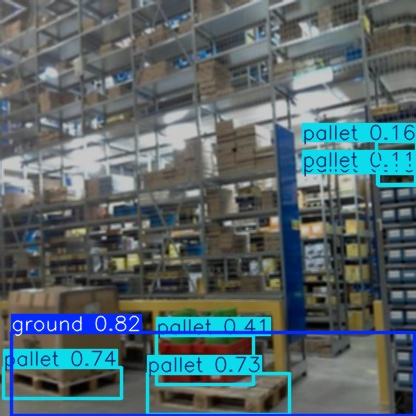

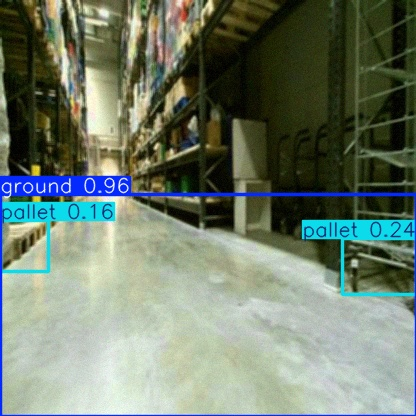

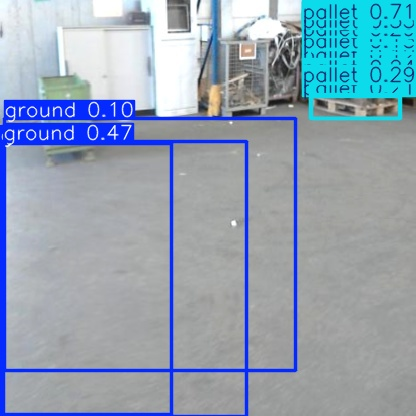

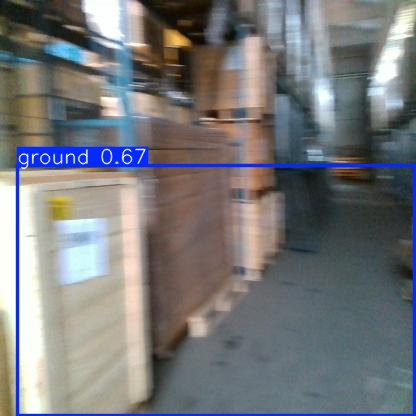

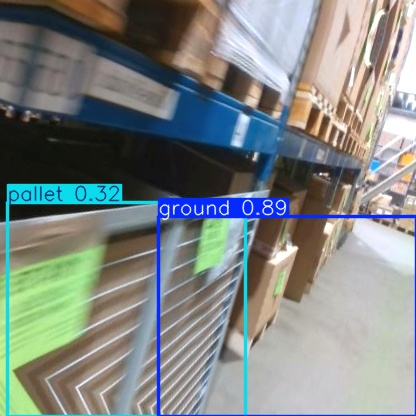

In [16]:
 # Define paths
best_model_path = 'runs/pallet_detection/best_model.pt'  # Path to the best model
test_images_dir = '/content/drive/MyDrive/Pallets_detection/YOLO_ObjectDetection_Dataset/test/images'  # Ensure this path is correct

# Check if test_images_dir exists
if not os.path.exists(test_images_dir):
    print(f"Test images directory does not exist: {test_images_dir}")
else:
    # Load the best model
    model = YOLO(best_model_path)

    # Step 7: Run Inference on Random Test Images
    # Get list of all test images
    test_images = glob.glob(os.path.join(test_images_dir, '*.jpg')) + \
                  glob.glob(os.path.join(test_images_dir, '*.png')) + \
                  glob.glob(os.path.join(test_images_dir, '*.jpeg'))

    # Check if test_images list is empty
    if not test_images:
        print("No test images found. Please check the test_images_dir path.")
    else:
        # Determine the number of images to select (up to 5)
        num_images_to_select = min(5, len(test_images))

        # Select 5 random test images
        random_test_images = random.sample(test_images, num_images_to_select)

        # Run inference on the selected random test images in batch
        results = model.predict(
            source=random_test_images,  # Pass the list of images
            conf=0.1,                   # Lowered confidence threshold
            save=True,
            imgsz=640,
            device='cuda' if torch.cuda.is_available() else 'cpu'
            # No need to specify 'save_dir'; use YOLO's default
        )

        print(f"Processed {len(random_test_images)} images.")

        # Step 8: Display Predicted Images
        # Dynamically find the latest 'predictX' directory in 'runs/detect'
        detect_dir = os.path.join('runs', 'detect')
        if not os.path.exists(detect_dir):
            print(f"Detection directory does not exist: {detect_dir}")
        else:
            # Find all 'predictX' directories using regex to match 'predict' followed by numbers
            predict_dirs = [d for d in os.listdir(detect_dir) if re.match(r'^predict\d+$', d)]

            if not predict_dirs:
                print("No 'predictX' directories found in 'runs/detect'.")
            else:
                # Sort directories based on the numerical value after 'predict'
                predict_dirs_sorted = sorted(
                    predict_dirs,
                    key=lambda x: int(re.findall(r'\d+', x)[0]) if re.findall(r'\d+', x) else -1,
                    reverse=True
                )

                # Ensure that we have at least one valid directory
                if predict_dirs_sorted:
                    latest_predict_dir = os.path.join(detect_dir, predict_dirs_sorted[0])
                    print(f"Latest predictions saved in: {latest_predict_dir}")

                    # Get the list of all predicted images in the latest directory
                    predicted_images = glob.glob(os.path.join(latest_predict_dir, '*.jpg')) + \
                                       glob.glob(os.path.join(latest_predict_dir, '*.png'))

                    # Check if predicted_images list is empty
                    if not predicted_images:
                        print("No predicted images found in the latest 'predictX' directory.")
                    else:
                        # Display the predictions for the selected random images
                        for img_path in predicted_images[:num_images_to_select]:
                            display(Image(filename=img_path, width=416))
                            print("\n")
                else:
                    print("No valid 'predictX' directories with numbers found.")
